In [1]:
import pandas as pd
import json
import numpy as np
import math
import warnings
from dynamodb_json import json_util
warnings.filterwarnings("ignore")
import boto3

dynamodb = boto3.client('dynamodb', aws_access_key_id="", aws_secret_access_key="", region_name="us-east-1")

def get_odds_mapping(list_odds):
    """
    Create a mapping of game IDs to average win probabilities for two teams from a list of odds data.

    Parameters:
    - list_odds (list): A list of odds data containing game information.

    Returns:
    - odds_mapping (dict): A dictionary where game IDs are keys, and values are dictionaries with
      "team_1_win_probs" and "team_2_win_probs" representing the average win probabilities for two teams.
    """
    odds_mapping = {}
    for game in list_odds:
        team_1_win_probs, team_2_win_probs = [], []
        game_id = game["gameid"]["S"]
        for odds_provider in game["odds"]["M"].keys():
            if len(game["odds"]["M"][odds_provider]["L"]) == 0:
                continue
            most_recent_odds = game["odds"]["M"][odds_provider]["L"][-1]["M"]
            team_1_win_probs.append(float(most_recent_odds["team_1_win_prob"]["N"]))
            team_2_win_probs.append(float(most_recent_odds["team_2_win_prob"]["N"]))
        odds_mapping[game_id] = {"team_1_win_probs": np.average(team_1_win_probs), "team_2_win_probs": np.average(team_2_win_probs)}
    return odds_mapping

def get_overtime(item, use_overtime):
    """
    Get a list of overtime flags for a game based on the score data.

    Parameters:
    - item (dict): A dictionary containing game information.
    - use_overtime (bool): Whether to include overtime flags.

    Returns:
    - overtime (list): A list of 0s and 1s indicating overtime for each game round.
    """
    overtime = []
    if not use_overtime:
        return [1 for i in range(len(item["teams"]["L"][0]["M"]["players"]["L"][0]["M"]["results"]["L"]))]
    if "results" not in item["teams"]["L"][0]["M"]:
        return None
    for game in range(len(item["teams"]["L"][0]["M"]["results"]["L"])):
        team_1_score = int(item["teams"]["L"][0]["M"]["results"]["L"][game]["M"]["rounds_won"]["N"])
        team_2_score = int(item["teams"]["L"][1]["M"]["results"]["L"][game]["M"]["rounds_won"]["N"])
        if (team_1_score > 13 or team_2_score > 13) and use_overtime:
            overtime.append(0)
        else:
            overtime.append(1)
    return overtime

def mask_result(data_list, mask_list):
    """
    Mask a list of data based on a list of masks.

    Parameters:
    - data_list (list): A list of data values.
    - mask_list (list): A list of masks.

    Returns:
    - result_list_final (list): A list of data values after applying the mask.
    """
    result_list = [x for x, mask in zip(data_list, mask_list) if mask != 0]
    result_list_final = [x for x in result_list if x != -1000]
    return result_list_final

def calculate_results(game_data, feature_name, overtime):
    """
    Calculate results for a specific game feature based on game data.

    Parameters:
    - game_data (dict): A dictionary containing game data.
    - feature_name (str): The name of the game feature to calculate.
    - overtime (list): A list of overtime flags for game rounds.

    Returns:
    - result (list): A list of calculated results for the feature.
    """
    feature_values = [float(game_data[f][feature_name]["N"]) if feature_name in game_data[f] else -1000 for f in game_data]
    return mask_result(feature_values, overtime)

def process_player_data(player_data, game_id, game_date, win_result, overtime, feature_keys, result_lists):
    """
    Process player data for a game and append results to result lists.

    Parameters:
    - player_data (dict): A dictionary containing player data.
    - game_id (str): The ID of the game.
    - game_date (str): The date of the game.
    - win_result (float): The win result for the player's team.
    - overtime (list): A list of overtime flags for game rounds.
    - feature_keys (list): A list of keys representing game features to process.
    - result_lists (dict): A dictionary of result lists for each game feature.
    """
    results = player_data.get("results", {"L": []})["L"]
    player_results = {key: [] for key in feature_keys}
    for game in results:
        game_data = game["M"]
        if any("NULL" in game_data.get(key, "") for key in feature_keys):
            continue
        for key in feature_keys:
            try: result = float(game_data.get(key, {"N": "-1000"})["N"])
            except KeyError: result = -1000.0
            player_results[key].append(result)
    # Append masked results for all games as arrays
    for key in feature_keys:
        if overtime is None:
            overtime = [1]*len(player_results[key])
        result = mask_result(player_results[key], overtime)
        result_lists[key].append(result)

def process_raw_data(data_frame, odds_mapping, result_keys, use_overtime=True):
    """
    Process raw game data, calculate results, and create a DataFrame.

    Parameters:
    - data_frame (list): A list of dictionaries containing raw game data.
    - odds_mapping (dict): A mapping of game IDs to average win probabilities.
    - result_keys (list): A list of keys representing game features to process.
    - use_overtime (bool): Whether to include overtime flags.

    Returns:
    - df_raw_data (pd.DataFrame): A DataFrame containing processed game data.
    """
    df_raw_data = pd.DataFrame()
    game_ids = []
    game_date = []
    player_id = []
    player_names = []
    team_id = []
    team_name = []
    opposing_id = []
    opposing_name = []
    result_lists = {key: [] for key in result_keys}
    win_result = []
    overtime_list = []
    win_probability = []
    tournament_id = []
    player_roles = []

    for item in data_frame:
        if "teams" in item:
            if not use_overtime: overtime = None
            else: overtime = get_overtime(item, use_overtime)
            for team_idx in range(len(item["teams"]["L"])):
                team = item["teams"]["L"][team_idx]["M"]
                opposing_team = item["teams"]["L"][abs(team_idx - 1)]["M"]
                for player_temp in team["players"]["L"]:
                    player = player_temp["M"]
                    process_player_data(
                        player,
                        item["gameid"]["S"],
                        item["date"]["S"],
                        team.get("win_result", {"N": 0.5}).get("N", 0.5),
                        overtime,
                        result_keys,
                        result_lists
                    )
                    game_ids.append(item["gameid"]["S"])  # Append the game_id here
                    game_date.append(item["date"]["S"])  # Append the game_date here
                    player_id.append(player["id"]["S"])  # Append the player_id here
                    player_names.append(player["username"]["S"])  # Append the player_name here
                    player_roles.append(player.get('role', {}).get('S'))
                    team_id.append(team["id"]["S"])  # Append the team_id here
                    team_name.append(team["name"]["S"])  # Append the team_name here
                    opposing_id.append(opposing_team["id"]["S"])  # Append the opposing_id here
                    opposing_name.append(opposing_team["name"]["S"])  # Append the opposing_name here
                    win_result.append(team.get("win_result", {"N": 0.5}).get("N", 0.5))  # Append the win_result here
                    overtime_list.append(overtime)  # Append the overtime here
                    game_odds = odds_mapping.get(item["gameid"]["S"], {"team_1_win_probs": 0.5, "team_2_win_probs": 0.5}) if odds_mapping is not None else None
                    team_number = str(team_idx+1)
                    win_probability.append(game_odds[f"team_{team_number}_win_probs"] if game_odds is not None else 0.5)
                    if "league_details" in item:
                        tournament_id.append(item["league_details"]["M"]["id"]["S"])
                    else:
                        tournament_id.append(None)
    for key in result_lists.keys():
        print(key, len(result_lists[key]))

    # Create a DataFrame from the collected data
    df_raw_data = pd.DataFrame({
        "game_id": game_ids,
        "game_date": game_date,
        "player_id": player_id,
        "player_name": player_names,
        "team_id": team_id,
        "team_name": team_name,
        "opposing_id": opposing_id,
        "opposing_name": opposing_name,
        "win_result": win_result,
        "win_probability": win_probability,
        "tournament_id": tournament_id,
        "player_role":player_roles,
        **result_lists  # Include the result data in the DataFrame
    })
    return df_raw_data

def get_data_from_table(table_name, testing):
    """
    Get data from a DynamoDB table.

    Parameters:
    - table_name (str): The name of the DynamoDB table to retrieve data from.
    - testing (bool): A flag indicating whether testing mode is enabled.

    Returns:
    - data_list (list): A list of data items retrieved from the table.
    """
    data_list = []
    response = dynamodb.scan(TableName=table_name)
    data_list.extend(response['Items'])
    counter = 0
    if testing == True:
        while 'LastEvaluatedKey' in response and counter < 2:
            response = dynamodb.scan(
                TableName=table_name,
                ExclusiveStartKey=response['LastEvaluatedKey']
            )
            data_list.extend(response['Items'])
            counter += 1
        return data_list
    while 'LastEvaluatedKey' in response:
        response = dynamodb.scan(
            TableName=table_name,
            ExclusiveStartKey=response['LastEvaluatedKey']
        )
        data_list.extend(response['Items'])
    return data_list

def get_raw_data_df(table_raw_name, table_odds_name, result_keys, filter_out_overtime=True, testing=False, odds=True):
    """
    Get and process raw game data and odds data, and return a DataFrame.

    Parameters:
    - table_raw_name (str): The name of the DynamoDB table containing raw game data.
    - table_odds_name (str): The name of the DynamoDB table containing odds data.
    - result_keys (list): A list of keys representing game features to process.
    - filter_out_overtime (bool): Whether to filter out overtime matches.
    - testing (bool): A flag indicating whether testing mode is enabled.

    Returns:
    - raw_data_df (pd.DataFrame): A DataFrame containing processed game data.
    """
    print("fetching raw data")
    df_raw_data = get_data_from_table(table_raw_name, testing)
    odds_mapping = None
    if odds:
        print("fetching odds data")
        df_odds = get_data_from_table(table_odds_name, testing)
        print("creating odds mapping")
        odds_mapping = get_odds_mapping(df_odds)
    print("creating raw data frame")
    print("df_raw_data:", len(df_raw_data))
    raw_data_df = process_raw_data(df_raw_data, odds_mapping, result_keys, filter_out_overtime)
    print("raw_data_df:", len(raw_data_df))
    raw_data_df['game_date'] = pd.to_datetime(raw_data_df['game_date'])
    raw_data_df = raw_data_df.sort_values(by='game_date', ascending=True).reset_index()
    print("df_raw_data:", len(df_raw_data))
    return raw_data_df

def process_downloaded_files(raw_data_file, odds_file, result_keys = ["kills", "deaths", "assists", "headshots", "KAST", "ADR"], use_overtime=False):
    print("fetching raw data")
    with open(raw_data_file, 'r') as fp:
        df_raw_data = json_util.dumps(json.load(fp))
    print("fetching odds data")
    with open(odds_file, 'r') as fp:
        df_odds = json_util.dumps(json.load(fp))
    odds_mapping = get_odds_mapping(df_odds)
    print("creating raw data frame")
    raw_data_df = process_raw_data(df_raw_data, odds_mapping, result_keys, use_overtime)
    raw_data_df['game_date'] = pd.to_datetime(raw_data_df['game_date'])
    raw_data_df = raw_data_df.sort_values(by='game_date', ascending=True).reset_index()
    return raw_data_df

In [37]:
pd.set_option('display.max_columns', None)

In [38]:
df_raw_rl = get_raw_data_df(
    "csgo-raw-completed-matches",
    "csgo-odds", 
    result_keys = ["ADR", "assists", "deaths", "fk_diff", "flash_assists", "headshots", "KAST", "kills"],
    testing=False,
    odds=False,
    filter_out_overtime=True #False uses overtime
)

fetching raw data
creating raw data frame
df_raw_data: 14005
ADR 139567
assists 139567
deaths 139567
fk_diff 139567
flash_assists 139567
headshots 139567
KAST 139567
kills 139567
raw_data_df: 139567
df_raw_data: 14005


In [22]:
# df_raw_rl.to_pickle('/home/frank/Desktop/Rimble/personalMlPipeline/ml-pipeline/cache/cacheNoOvertime/df_raw_rl.pkl')
df_raw_rl = pd.read_pickle('/home/frank/Desktop/Rimble/personalMlPipeline/ml-pipeline/cache/cacheNoOvertime/df_raw_rl.pkl')

In [23]:
df_raw_rl_filtered = df_raw_rl[df_raw_rl['game_date'] >= '2023-10-01']
df_raw_rl_filtered.columns = map(str.lower, df_raw_rl_filtered.columns)
df_raw_rl_filtered = df_raw_rl_filtered.rename(columns={"assists":'assist', "flash_assists":"flashAssists", 'fk_diff':'fkdiff'})
df_raw_rl_filtered

,index,game_id,game_date,player_id,player_name,team_id,team_name,opposing_id,opposing_name,win_result,...,tournament_id,player_role,adr,assist,deaths,fkdiff,flashAssists,headshots,kast,kills
87968,51769,2367032,2023-10-01,22279,PR,11176,MOUZ NXT,7187,Nexus,1,...,7385,None,[],[],[],[],[],[],[],[]
87969,51766,2367032,2023-10-01,21972,Neityu,11176,MOUZ NXT,7187,Nexus,1,...,7385,None,[],[],[],[],[],[],[],[]
87970,51767,2367032,2023-10-01,21983,Chr1zN,11176,MOUZ NXT,7187,Nexus,1,...,7385,None,[],[],[],[],[],[],[],[]
87971,51768,2367032,2023-10-01,20872,Nexius,11176,MOUZ NXT,7187,Nexus,1,...,7385,None,[],[],[],[],[],[],[],[]
87972,51770,2367036,2023-10-01,19817,s0und,7187,Nexus,11331,Websterz,1,...,7452,None,[],[],[],[],[],[],[],[]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139562,107626,2373006,2024-06-10,8891,Nodios,11571,Gaimin Gladiators,10873,Enterprise,0,...,7886,None,[78.8],[5.0],[15.0],[-1.0],[0.0],[8.0],[60.0],[13.0]
139563,107627,2373006,2024-06-10,20300,kraghen,11571,Gaimin Gladiators,10873,Enterprise,0,...,7886,None,[64.8],[4.0],[17.0],[-2.0],[0.0],[5.0],[65.0],[12.0]
139564,107628,2373006,2024-06-10,13077,Patti,11571,Gaimin Gladiators,10873,Enterprise,0,...,7886,None,[63.6],[3.0],[16.0],[-2.0],[1.0],[3.0],[50.0],[14.0]
139565,107615,2372899,2024-06-10,23414,jackasmo,12426,Passion UA,12388,Space,1,...,7852,None,"[110.2, 82.2, 54.9]","[7.0, 6.0, 6.0]","[11.0, 16.0, 19.0]","[0.0, -2.0, -3.0]","[3.0, 0.0, 2.0]","[11.0, 11.0, 6.0]","[94.1, 66.7, 58.3]","[18.0, 15.0, 9.0]"


In [2]:
# df_raw_rl_filtered.to_pickle('/home/frank/Desktop/Rimble/personalMlPipeline/ml-pipeline/cache/cacheNoOvertime/df_raw_rl_filtered.pkl')
# df_raw_rl_filtered = pd.read_pickle('/home/frank/Desktop/Rimble/personalMlPipeline/ml-pipeline/cache/cacheNoOvertime/df_raw_rl_filtered.pkl')

In [3]:
temp = list(df_raw_rl_filtered["kills"])
arr = []
for x in temp:
    arr += x
temp = np.array(arr)
np.mean(temp)

14.487719427644196

In [4]:
import pandas as pd
import numpy as np

def custom_rolling(group, stats, max_n, filter_condition=None):
    """
    Compute rolling statistics for a given group of data.

    Parameters:
    -----------
    group : pd.DataFrame
        DataFrame group on which to compute the rolling statistics.
    stats : list of str
        List of statistics to compute.
    max_n : int
        Maximum number of observations to consider.
    filter_condition : callable, optional
        A function to filter rows for the computation (default is None).

    Returns:
    --------
    dict
        Dictionary of rolling values for each statistic.
    """
    valid_stats = {stat: [] for stat in stats}
    rolling_values = {stat: {} for stat in stats}
    for _, row in group.iterrows():
        for stat in stats:
            rolling_values[stat][row.name] = valid_stats[stat][-max_n:].copy()
            if filter_condition is None or filter_condition(row):
                if stat not in row or row[stat] is None or (type(row[stat]) == list and len(row[stat]) == 0): continue
                valid_stats[stat].append(row[stat])
    return rolling_values

def compute_rolling_window(df, stats, max_n, groupby, filter_condition=None):
    """
    Compute rolling window statistics for a DataFrame.

    Parameters:
    -----------
    df : pd.DataFrame
        DataFrame on which to compute the rolling statistics.
    stats : list of str
        List of statistics to compute.
    max_n : int
        Maximum number of observations to consider.
    groupby : list of str
        Columns to group by.
    filter_condition : callable, optional
        A function to filter rows for the computation (default is None).

    Returns:
    --------
    dict
        Dictionary of rolling window statistics.
    """
    rolling_values_series = df.groupby(groupby, sort=False).apply(lambda group: custom_rolling(group, stats, max_n, filter_condition))
    rolling_windows = {}
    for stat in stats:
        flattened_values = {}
        for group_key, stats_dict in rolling_values_series.items():
            if stat in stats_dict:
                flattened_values.update(stats_dict[stat])
        rolling_windows[stat] = pd.Series(flattened_values)

    return rolling_windows


def last_n_stats_per_player(df, stat_list, n_list=[3,5,10], use_games=True,
                            custom_suffix=None,
                            filter_condition=None, groupby=["player"]):
    """
    Compute last N stats on a per player game or avg stat per match basis

    Parameters:
    df (pandas dataframe): DataFrame with games data
    stat_list (list of str): List of column name of stat to compute e.g. ['kills', 'assists']
    n_list (list of int): List of N values to compute e.g. [5, 10]
    use_games (bool): Whether to use game level data or use match data
    custom_suffix (str or None): Custom text to append to the column names (default is None)
    match_level_avg (bool): Whether to take an avg on a per match basis or return raw value, default is True
    filter_condition (func): A function that gets applied to the row if we want to keep it (wins/loss)
    groupby (list of str): tells what to groupby (we need to change for matchup and so forth)
    Returns:
    df_modified: Modified DataFrame with additional columns:
        {stat}_last_{n}: Stat value for last n games
    """
    # Input validation
    if len(df) == 0:
        return pd.DataFrame()

    df_modified = df.copy()
    # Compute optimized rolling window
    max_n = max(n_list)
    rolling_window_mapping = compute_rolling_window(df, stat_list, max_n, groupby ,filter_condition)
    # Compute last n stats for each N
    for stat in stat_list:
        rolling_window = rolling_window_mapping[stat]
        for n in n_list:
            # Flatten the list if using games. Takes n newest games, then takes n newest matches
            if use_games:
                last_n_stats = rolling_window.apply(lambda x: [item for sublist in x for item in sublist][-n:])
            # If not using games and also not calculating match-level averages
            else:
                last_n_stats = rolling_window.apply(lambda x: x[-n:]) #Takes n newest games, then averages them.
                last_n_stats = last_n_stats.apply(lambda x: [sum(sublist) / len(sublist) if (type(sublist) == list and len(sublist) != 0) else sublist for sublist in x]) 
            stat_suffix = f'{stat}_last_{n}'
            stat_std_suffix = f'std_{stat}_last_{n}'
            if custom_suffix:
                stat_suffix = f'{stat_suffix}_{custom_suffix}'
                stat_std_suffix = f'{stat_std_suffix}_{custom_suffix}'
            df_modified[f'{stat_suffix}'] = last_n_stats
            df_modified[f'{stat_std_suffix}'] = df_modified[f'{stat_suffix}'].apply(lambda row: np.std(list(map(float, row))) if len(row) > 1 else np.nan)
    return df_modified

def filter_wins(row):
    if 'win_result' not in row: return False
    return int(row['win_result']) == 1

def filter_losses(row):
    if 'win_result' not in row: return False
    return  int(row['win_result']) == 0

def generate_target(df, stat_list, use_median=True):
    """
    Generate target statistics for a DataFrame.

    Parameters:
    -----------
    df : pd.DataFrame
        DataFrame on which to generate the target statistics.
    stat_list : list of str
        List of statistics to generate.
    use_median : bool, optional
        Whether to use the median or mean (default is True).

    Returns:
    --------
    pd.DataFrame
        DataFrame with additional columns for the expected values of the specified statistics.
    """
    for stat in stat_list:
        if stat == "win_result": use_median = False
        if use_median:
            df[f"{stat}_expected"] = df[stat].apply(lambda row: np.median(row)).round(2)
        else:
            df[f"{stat}_expected"] = df[stat].apply(lambda row: np.mean(list(map(float, row)))).round(2)
    return df



In [44]:
STATS = ["adr", "assist", "deaths", "fkdiff", "flashAssists", "headshots", "kast", "kills"]
df_processed_1 = last_n_stats_per_player(df_raw_rl_filtered,
                                         STATS,
                                         n_list=[2, 3, 5, 10], use_games=True, custom_suffix=None,
                                         filter_condition=None, groupby=["player_id"])

df_processed_1 = last_n_stats_per_player(df_processed_1,
                                         STATS,
                                         n_list=[2, 3, 5, 10], use_games=True, custom_suffix="win",
                                         filter_condition=filter_wins, groupby=["player_id"])

df_processed_1 = last_n_stats_per_player(df_processed_1,
                                         STATS,
                                         n_list=[2, 3, 5, 10], use_games=True, custom_suffix="loss",
                                         filter_condition=filter_losses, groupby=["player_id"])

df_processed_1 = last_n_stats_per_player(df_processed_1,
                                         STATS,
                                         n_list=[2, 3, 5, 10], use_games=True, custom_suffix="matchup",
                                         groupby=["player_id", "team_id", "opposing_id"])

df_processed_1 = generate_target(df_processed_1,
                                 STATS,
                                 use_median=False)


#Add bias column
df_processed_1['bias'] = 1

In [45]:
df_processed_1 = generate_target(df_processed_1, STATS, use_median=False)

In [46]:
# df_processed_1.to_pickle('/home/frank/Desktop/Rimble/personalMlPipeline/ml-pipeline/cache/cacheNoOvertime/df_processed_1.pkl')

In [47]:
import pandas as pd
import numpy as np
import json
import re

class Imputer:
    """
    A class used to impute missing values in a dataset based on various levels of grouping.

    ...

    Attributes
    ----------
    df : pd.DataFrame
        The DataFrame to be imputed.
    stat_columns : list
        The columns which contain the statistics to be imputed.
    use_median : bool, optional
        A flag to toggle between using median or mean for imputation (default is True).
    role : str, optional
        The role to consider for role-based imputation (default is None).
    tournament_imputation : bool, optional
        A flag to enable tournament-based imputation (default is False).
    blacklist_tournaments : list, optional
        A list of tournament IDs to exclude from tournament-based imputation (default is None).
    statistics_cache : dict
        A cache to store the computed statistics used for imputation.

    Methods
    -------
    calculate_statistics():
        Calculates and caches the statistics used for imputation.
    impute_stat(stat, player_team_id, opposing_team_id, tournament_id):
        Imputes a single statistic based on various levels of grouping.
    fill_missing_values():
        Fills missing values in the DataFrame based on the cached statistics.
    convert_to_json_serializable():
        Converts the statistics cache to a JSON-serializable format.
    """

    def __init__(self, df, stat_columns, use_median=True, role=None,
                 tournament_imputation=False, blacklist_tournaments=None):
        self.df = df.copy()
        self.stat_columns = stat_columns
        self.use_median = use_median
        self.role = role
        self.tournament_imputation = tournament_imputation
        self.blacklist_tournaments = blacklist_tournaments if blacklist_tournaments else []
        self.statistics_cache = {}
        self.calculate_statistics()

    def calculate_statistics(self):
        agg_func = 'median' if self.use_median else 'mean'
        stat_names_list = set()
        for stat_name in self.stat_columns:
            stat_temp = stat_name.split('_')[0]
            stat = f"{stat_temp}_expected"
            stat_names_list.add(stat)
        stat_names_list = list(stat_names_list)
        for stat in stat_names_list:
            if "std" in stat:
                continue    
            stat_cache = {
                'global': {},
                'team': {},
                'matchup': {},
                'tournament': {},
            }
            # Global role-based statistic
            if self.role:
                stat_cache['global']['role'] = self.df[self.df['role'] == self.role][stat].agg(agg_func)
            stat_cache['global']['all'] = self.df[stat].agg(agg_func)
            # Global statistic
            grouping_params = ['team_id', 'role'] if self.role else ['team_id']
            counts = self.df.groupby(grouping_params).size()
            sufficient_data_teams = counts[counts >= 500 if stat != 'winresult' else 500]
            filtered_df = self.df.set_index(grouping_params).loc[sufficient_data_teams.index]
            stat_cache['team'] = filtered_df.groupby(grouping_params)[stat].agg(agg_func)
            grouping_params = ['team_id', 'opposing_id', 'role'] if self.role else ['team_id', 'opposing_id']
            matchup_counts = self.df.groupby(grouping_params).size()
            sufficient_data_matchups = matchup_counts[matchup_counts > 0 if stat != "winresult" else 50]
            filtered_matchup_df = self.df.set_index(grouping_params).loc[sufficient_data_matchups.index]
            stat_cache['matchup'] = filtered_matchup_df.groupby(grouping_params)[stat].agg(agg_func)
            if self.tournament_imputation:
                grouping_params = ['tournament_id', 'role'] if self.role else ['tournament_id']
                tournament_counts = self.df.groupby(grouping_params).size()
                sufficient_data_tournaments = tournament_counts[tournament_counts >= 500 if stat != "winresult" else 500]
                filtered_tournament_df = self.df.set_index(grouping_params).loc[sufficient_data_tournaments.index]
                stat_cache['tournament'] = filtered_tournament_df.groupby(grouping_params)[stat].agg(agg_func)
            self.statistics_cache[stat] = stat_cache

    def impute_stat(self, stat, player_team_id, opposing_team_id, tournament_id):
        """
        Imputes a single statistic based on various levels of grouping.

        Parameters:
        -----------
        stat : str
            The statistic to be imputed.
        player_team_id : str
            The ID of the player's team.
        opposing_team_id : str
            The ID of the opposing team.
        tournament_id : str
            The ID of the tournament.

        Returns:
        --------
        float
            The imputed value for the specified statistic.
        """
        cache = self.statistics_cache[stat]
        grouping_params = (player_team_id, opposing_team_id, self.role) if self.role else (player_team_id, opposing_team_id)
        if grouping_params in cache['matchup'].index:
            return cache['matchup'][grouping_params]
        grouping_params = (player_team_id, self.role) if self.role else player_team_id
        if grouping_params in cache['team'].index:
            return cache['team'][grouping_params]
        if self.tournament_imputation and tournament_id not in self.blacklist_tournaments:
            grouping_params = (tournament_id, self.role) if self.role else tournament_id
            if grouping_params in cache['tournament'].index:
                return cache['tournament'][grouping_params]
        return cache['global']['role'] if self.role and 'role' in cache['global'] else cache['global']['all']

    def fill_missing_values(self):
        """Fills missing values in the DataFrame based on the cached statistics."""
        for stat in self.stat_columns:
            if "std" in stat:
                mean = np.nanmean(list(self.df[stat]))
                self.df[stat] = self.df[stat].fillna(mean)
            else:
                stat_temp = stat.split('_')[0]
                stat_target_name = f"{stat_temp}_expected"
                match = re.search(r'\d+', stat)
                expected_length = int(match.group())
                self.df[f'{stat}_extension'] = self.df.apply(
                    lambda x: self.impute_stat(stat_target_name, x['team_id'], x['opposing_id'], x['tournament_id']),
                    axis=1
                )
                mask = self.df[stat].apply(len) < expected_length
                self.df.loc[mask, stat] = self.df.loc[mask].apply(
                    lambda row: [row[f'{stat}_extension']] * (expected_length - len(row[stat])) + row[stat],
                    axis=1
                )
                #self.df.drop(f'{stat}_extension', axis=1, inplace=True)
        stat_columns = [stat for stat in self.stat_columns if "std" not in stat]
        missing_mask = self.df[stat_columns].applymap(lambda cell: any(x is None for x in cell)).any(axis=1)
        missing_indices = self.df[missing_mask].index
        for idx in missing_indices:
            player_team_id = self.df.at[idx, 'team_id']
            opposing_team_id = self.df.at[idx, 'opposing_id']
            tournament_id = self.df.at[idx, 'tournament_id']
            for stat in stat_columns:
                stat_temp = stat.split('_')[0]
                stat_target_name = f"{stat_temp}_expected"
                if any(pd.isnull(self.df.at[idx, stat])):
                    self.df.at[idx, stat] = ([self.impute_stat(stat_target_name, player_team_id, opposing_team_id, tournament_id)] * sum(x is None for x in self.df.at[idx, stat]) 
                                            + list(filter(lambda val: val is not None, self.df.at[idx, stat])))
        return self.df

    def convert_to_json_serializable(self):
        """
        Converts the statistics cache to a JSON-serializable format.

        Returns:
        --------
        dict
            The statistics cache in a JSON-serializable format.
        """
        json_serializable_cache = {}
        for stat, caches in self.statistics_cache.items():
            clean_stat = stat.replace('_expected', '')
            json_serializable_cache[clean_stat] = {}
            for cache_type, cache in caches.items():
                if isinstance(cache, pd.Series):
                    nested_dict = {}
                    for index, value in cache.items():
                        keys = index if isinstance(index, tuple) else (index,)
                        current_dict = nested_dict
                        for key in keys[:-1]:
                            current_dict = current_dict.setdefault(key, {})
                        current_dict[keys[-1]] = value
                    json_serializable_cache[clean_stat][cache_type] = nested_dict
                elif isinstance(cache, pd.DataFrame):
                    # Handle DataFrame case if needed
                    pass
                elif isinstance(cache, dict):
                    json_serializable_cache[clean_stat][cache_type] = cache
                else:
                    json_serializable_cache[clean_stat][cache_type] = cache.tolist() if hasattr(cache, 'tolist') else cache
        return json_serializable_cache
    
    def fill_centered_std(self, df):
        """
        Adds centered std to the table
        Parameters:
        -----------
        df : DataFrame
            DataFrame to be filled.

        Returns:
        --------
        df : DataFrame
            DataFrame with filled centered std
        """
        matching_columns = []
        for column in df.columns:
            if "std" in column:
                matching_columns.append(column)
        for column in matching_columns:
            std = np.nanmean(list(df[column]))
            df[f'centered_{column}'] = df[column].apply(lambda x: np.round(x - std, 3))
        return df

In [48]:
for k in df_processed_1.columns:
    if 'win_result' in k:
        df_processed_1[k.replace("win_result", "winresult")] = df_processed_1[k]

df_processed_1

,index,game_id,game_date,player_id,player_name,team_id,team_name,opposing_id,opposing_name,win_result,win_probability,tournament_id,player_role,adr,assist,deaths,fkdiff,flashAssists,headshots,kast,kills,adr_last_2,std_adr_last_2,adr_last_3,std_adr_last_3,adr_last_5,std_adr_last_5,adr_last_10,std_adr_last_10,assist_last_2,std_assist_last_2,assist_last_3,std_assist_last_3,assist_last_5,std_assist_last_5,assist_last_10,std_assist_last_10,deaths_last_2,std_deaths_last_2,deaths_last_3,std_deaths_last_3,deaths_last_5,std_deaths_last_5,deaths_last_10,std_deaths_last_10,fkdiff_last_2,std_fkdiff_last_2,fkdiff_last_3,std_fkdiff_last_3,fkdiff_last_5,std_fkdiff_last_5,fkdiff_last_10,std_fkdiff_last_10,flashAssists_last_2,std_flashAssists_last_2,flashAssists_last_3,std_flashAssists_last_3,flashAssists_last_5,std_flashAssists_last_5,flashAssists_last_10,std_flashAssists_last_10,headshots_last_2,std_headshots_last_2,headshots_last_3,std_headshots_last_3,headshots_last_5,std_headshots_last_5,headshots_last_10,std_headshots_last_10,kast_last_2,std_kast_last_2,kast_last_3,std_kast_last_3,kast_last_5,std_kast_last_5,kast_last_10,std_kast_last_10,kills_last_2,std_kills_last_2,kills_last_3,std_kills_last_3,kills_last_5,std_kills_last_5,kills_last_10,std_kills_last_10,adr_last_2_win,std_adr_last_2_win,adr_last_3_win,std_adr_last_3_win,adr_last_5_win,std_adr_last_5_win,adr_last_10_win,std_adr_last_10_win,assist_last_2_win,std_assist_last_2_win,assist_last_3_win,std_assist_last_3_win,assist_last_5_win,std_assist_last_5_win,assist_last_10_win,std_assist_last_10_win,deaths_last_2_win,std_deaths_last_2_win,deaths_last_3_win,std_deaths_last_3_win,deaths_last_5_win,std_deaths_last_5_win,deaths_last_10_win,std_deaths_last_10_win,fkdiff_last_2_win,std_fkdiff_last_2_win,fkdiff_last_3_win,std_fkdiff_last_3_win,fkdiff_last_5_win,std_fkdiff_last_5_win,fkdiff_last_10_win,std_fkdiff_last_10_win,flashAssists_last_2_win,std_flashAssists_last_2_win,flashAssists_last_3_win,std_flashAssists_last_3_win,flashAssists_last_5_win,std_flashAssists_last_5_win,flashAssists_last_10_win,std_flashAssists_last_10_win,headshots_last_2_win,std_headshots_last_2_win,headshots_last_3_win,std_headshots_last_3_win,headshots_last_5_win,std_headshots_last_5_win,headshots_last_10_win,std_headshots_last_10_win,kast_last_2_win,std_kast_last_2_win,kast_last_3_win,std_kast_last_3_win,kast_last_5_win,std_kast_last_5_win,kast_last_10_win,std_kast_last_10_win,kills_last_2_win,std_kills_last_2_win,kills_last_3_win,std_kills_last_3_win,kills_last_5_win,std_kills_last_5_win,kills_last_10_win,std_kills_last_10_win,adr_last_2_loss,std_adr_last_2_loss,adr_last_3_loss,std_adr_last_3_loss,adr_last_5_loss,std_adr_last_5_loss,adr_last_10_loss,std_adr_last_10_loss,assist_last_2_loss,std_assist_last_2_loss,assist_last_3_loss,std_assist_last_3_loss,assist_last_5_loss,std_assist_last_5_loss,assist_last_10_loss,std_assist_last_10_loss,deaths_last_2_loss,std_deaths_last_2_loss,deaths_last_3_loss,std_deaths_last_3_loss,deaths_last_5_loss,std_deaths_last_5_loss,deaths_last_10_loss,std_deaths_last_10_loss,fkdiff_last_2_loss,std_fkdiff_last_2_loss,fkdiff_last_3_loss,std_fkdiff_last_3_loss,fkdiff_last_5_loss,std_fkdiff_last_5_loss,fkdiff_last_10_loss,std_fkdiff_last_10_loss,flashAssists_last_2_loss,std_flashAssists_last_2_loss,flashAssists_last_3_loss,std_flashAssists_last_3_loss,flashAssists_last_5_loss,std_flashAssists_last_5_loss,flashAssists_last_10_loss,std_flashAssists_last_10_loss,headshots_last_2_loss,std_headshots_last_2_loss,headshots_last_3_loss,std_headshots_last_3_loss,headshots_last_5_loss,std_headshots_last_5_loss,headshots_last_10_loss,std_headshots_last_10_loss,kast_last_2_loss,std_kast_last_2_loss,kast_last_3_loss,std_kast_last_3_loss,kast_last_5_loss,std_kast_last_5_loss,kast_last_10_loss,std_kast_last_10_loss,kills_last_2_loss,std_kills_last_2_loss,kills_last_3_loss,std_kills_last_3_loss,kills_last_5_loss,std_kills_last_5_loss,kills_last_10_loss,std_kills_last_10_loss,adr_last_2_matchup,std_adr_la

In [49]:
subString = ["adr_last", "assist_last", "deaths_last", "fkdiff_last", "flashAssists_last", "headshots_last", "kast_last", "kills_last"]

matching_columns = []
# Iterate through the columns and check for substrings
for column in df_processed_1.columns:
    if any(substring in column for substring in subString) and not "expected" in column:
        matching_columns.append(column)
len(matching_columns)

256

In [50]:
imputer = Imputer(df_processed_1, matching_columns, use_median=False, role=None, 
                  tournament_imputation=False, blacklist_tournaments=[])
df_filled = imputer.fill_missing_values()
df_filled = imputer.fill_centered_std(df_filled)
# Output the imputer statistics as JSON
json = imputer.convert_to_json_serializable()

In [51]:
df_filled = df_filled.drop(["tournament_id", "player_role"], axis = 1)

In [52]:
# df_filled.to_pickle('/home/frank/Desktop/Rimble/personalMlPipeline/ml-pipeline/cache/cacheNoOvertime/df_filled.pkl')

In [53]:
import pandas as pd

def weighted_average(data_points, decaying_weight):
    """
    Calculate the weighted average of a list of data points using a decaying weight factor.

    Args:
        data_points (list): List of numeric data points.
        decaying_weight (float): Decaying weight factor for weighting data points.

    Returns:
        float: Weighted average of the data points.
    """
    weight = 1.0  # Initial weight for the newest data point
    weighted_sum = 0.0
    total_weight = 0.0
    for value in reversed(data_points):
        weighted_sum += float(value) * weight
        total_weight += weight
        weight *= decaying_weight  # Decrease the weight by X% for the next data point

    if total_weight == 0:
        return 0  # To avoid division by zero
    else:
        return weighted_sum / total_weight

def stat_aggregator(df, stat_list, decaying_n_stat_weight=1, decaying_match_stat_weight=1):
    """
    Calculate weighted averages for specified statistics in a DataFrame.

    Args:
        df (pd.DataFrame): DataFrame containing statistical data.
        stat_list (list): List of statistics to be aggregated.
        decaying_weight (float, optional): Decaying weight factor for weighting data points. Default is 1.

    Returns:
        pd.DataFrame: DataFrame with aggregated statistics.
    """
    df_temp = df.copy()
    for stat in stat_list:
        list_of_columns = [column_name for column_name in df_temp.columns if stat in column_name and "expected" not in column_name and "std" not in column_name and "extension" not in column_name]
        print(list_of_columns)
        df_temp[list_of_columns] = pd.concat([df_temp[[list_of_columns[0]]].applymap(lambda x: weighted_average(x, decaying_match_stat_weight)), df_temp[list_of_columns[1:]].applymap(lambda x: weighted_average(x, decaying_n_stat_weight))], axis = 1)

    return df_temp


In [54]:
STATS = ["adr", "assist", "deaths", "fkdiff", "flashAssists", "headshots", "kast", "kills"]
df_processed_final = stat_aggregator(df_filled, 
                                     STATS,
                                     decaying_n_stat_weight=0.8)

['adr', 'adr_last_2', 'adr_last_3', 'adr_last_5', 'adr_last_10', 'adr_last_2_win', 'adr_last_3_win', 'adr_last_5_win', 'adr_last_10_win', 'adr_last_2_loss', 'adr_last_3_loss', 'adr_last_5_loss', 'adr_last_10_loss', 'adr_last_2_matchup', 'adr_last_3_matchup', 'adr_last_5_matchup', 'adr_last_10_matchup']
['assist', 'assist_last_2', 'assist_last_3', 'assist_last_5', 'assist_last_10', 'assist_last_2_win', 'assist_last_3_win', 'assist_last_5_win', 'assist_last_10_win', 'assist_last_2_loss', 'assist_last_3_loss', 'assist_last_5_loss', 'assist_last_10_loss', 'assist_last_2_matchup', 'assist_last_3_matchup', 'assist_last_5_matchup', 'assist_last_10_matchup']
['deaths', 'deaths_last_2', 'deaths_last_3', 'deaths_last_5', 'deaths_last_10', 'deaths_last_2_win', 'deaths_last_3_win', 'deaths_last_5_win', 'deaths_last_10_win', 'deaths_last_2_loss', 'deaths_last_3_loss', 'deaths_last_5_loss', 'deaths_last_10_loss', 'deaths_last_2_matchup', 'deaths_last_3_matchup', 'deaths_last_5_matchup', 'deaths_last

In [61]:
df_processed_final

,index,game_id,game_date,player_id,player_name,team_id,team_name,opposing_id,opposing_name,win_result,win_probability,adr,assist,deaths,fkdiff,flashAssists,headshots,kast,kills,adr_last_2,std_adr_last_2,adr_last_3,std_adr_last_3,adr_last_5,std_adr_last_5,adr_last_10,std_adr_last_10,assist_last_2,std_assist_last_2,assist_last_3,std_assist_last_3,assist_last_5,std_assist_last_5,assist_last_10,std_assist_last_10,deaths_last_2,std_deaths_last_2,deaths_last_3,std_deaths_last_3,deaths_last_5,std_deaths_last_5,deaths_last_10,std_deaths_last_10,fkdiff_last_2,std_fkdiff_last_2,fkdiff_last_3,std_fkdiff_last_3,fkdiff_last_5,std_fkdiff_last_5,fkdiff_last_10,std_fkdiff_last_10,flashAssists_last_2,std_flashAssists_last_2,flashAssists_last_3,std_flashAssists_last_3,flashAssists_last_5,std_flashAssists_last_5,flashAssists_last_10,std_flashAssists_last_10,headshots_last_2,std_headshots_last_2,headshots_last_3,std_headshots_last_3,headshots_last_5,std_headshots_last_5,headshots_last_10,std_headshots_last_10,kast_last_2,std_kast_last_2,kast_last_3,std_kast_last_3,kast_last_5,std_kast_last_5,kast_last_10,std_kast_last_10,kills_last_2,std_kills_last_2,kills_last_3,std_kills_last_3,kills_last_5,std_kills_last_5,kills_last_10,std_kills_last_10,adr_last_2_win,std_adr_last_2_win,adr_last_3_win,std_adr_last_3_win,adr_last_5_win,std_adr_last_5_win,adr_last_10_win,std_adr_last_10_win,assist_last_2_win,std_assist_last_2_win,assist_last_3_win,std_assist_last_3_win,assist_last_5_win,std_assist_last_5_win,assist_last_10_win,std_assist_last_10_win,deaths_last_2_win,std_deaths_last_2_win,deaths_last_3_win,std_deaths_last_3_win,deaths_last_5_win,std_deaths_last_5_win,deaths_last_10_win,std_deaths_last_10_win,fkdiff_last_2_win,std_fkdiff_last_2_win,fkdiff_last_3_win,std_fkdiff_last_3_win,fkdiff_last_5_win,std_fkdiff_last_5_win,fkdiff_last_10_win,std_fkdiff_last_10_win,flashAssists_last_2_win,std_flashAssists_last_2_win,flashAssists_last_3_win,std_flashAssists_last_3_win,flashAssists_last_5_win,std_flashAssists_last_5_win,flashAssists_last_10_win,std_flashAssists_last_10_win,headshots_last_2_win,std_headshots_last_2_win,headshots_last_3_win,std_headshots_last_3_win,headshots_last_5_win,std_headshots_last_5_win,headshots_last_10_win,std_headshots_last_10_win,kast_last_2_win,std_kast_last_2_win,kast_last_3_win,std_kast_last_3_win,kast_last_5_win,std_kast_last_5_win,kast_last_10_win,std_kast_last_10_win,kills_last_2_win,std_kills_last_2_win,kills_last_3_win,std_kills_last_3_win,kills_last_5_win,std_kills_last_5_win,kills_last_10_win,std_kills_last_10_win,adr_last_2_loss,std_adr_last_2_loss,adr_last_3_loss,std_adr_last_3_loss,adr_last_5_loss,std_adr_last_5_loss,adr_last_10_loss,std_adr_last_10_loss,assist_last_2_loss,std_assist_last_2_loss,assist_last_3_loss,std_assist_last_3_loss,assist_last_5_loss,std_assist_last_5_loss,assist_last_10_loss,std_assist_last_10_loss,deaths_last_2_loss,std_deaths_last_2_loss,deaths_last_3_loss,std_deaths_last_3_loss,deaths_last_5_loss,std_deaths_last_5_loss,deaths_last_10_loss,std_deaths_last_10_loss,fkdiff_last_2_loss,std_fkdiff_last_2_loss,fkdiff_last_3_loss,std_fkdiff_last_3_loss,fkdiff_last_5_loss,std_fkdiff_last_5_loss,fkdiff_last_10_loss,std_fkdiff_last_10_loss,flashAssists_last_2_loss,std_flashAssists_last_2_loss,flashAssists_last_3_loss,std_flashAssists_last_3_loss,flashAssists_last_5_loss,std_flashAssists_last_5_loss,flashAssists_last_10_loss,std_flashAssists_last_10_loss,headshots_last_2_loss,std_headshots_last_2_loss,headshots_last_3_loss,std_headshots_last_3_loss,headshots_last_5_loss,std_headshots_last_5_loss,headshots_last_10_loss,std_headshots_last_10_loss,kast_last_2_loss,std_kast_last_2_loss,kast_last_3_loss,std_kast_last_3_loss,kast_last_5_loss,std_kast_last_5_loss,kast_last_10_loss,std_kast_last_10_loss,kills_last_2_loss,std_kills_last_2_loss,kills_last_3_loss,std_kills_last_3_loss,kills_last_5_loss,std_kills_last_5_loss,kills_last_10_loss,std_kills_last_10_loss,adr_last_2_matchup,std_adr_last_2_matchup,adr_last_3_ma

In [62]:
df_processed_final = df_processed_final.dropna()
df_processed_final = df_processed_final[df_processed_final['game_date'] > '2023-10-01']

In [6]:
#Overtime, 14.399534154373972
#No Overtime, 13.445821312781623
df_processed_final['kills'].mean(axis=0)

14.399534154373972

In [2]:
# df_processed_final.to_pickle("/home/frank/Desktop/Rimble/personalMlPipeline/ml-pipeline/cache/cacheNoOvertime/df_processed_final.pkl")
df_processed_final = pd.read_pickle("/home/frank/Desktop/Rimble/personalMlPipeline/ml-pipeline/cache/cacheNoOvertime/df_processed_final.pkl")

In [3]:
df_processed_final_OT = pd.read_pickle("/home/frank/Desktop/Rimble/personalMlPipeline/ml-pipeline/cache/cacheOvertime/df_processed_final.pkl")

In [7]:
STATS = ["adr", "assist", "deaths", "fkdiff", "flashAssists", "headshots", "kast", "kills"]
test = df_processed_final_OT[['player_id', 'game_id'] + [f'{stat}_expected' for stat in STATS]]
mapper = {f'{stat}_expected' : f'{stat}_expected_OT' for stat in STATS}
print(mapper)
test = test.rename(columns = mapper)
test

{'adr_expected': 'adr_expected_OT', 'assist_expected': 'assist_expected_OT', 'deaths_expected': 'deaths_expected_OT', 'fkdiff_expected': 'fkdiff_expected_OT', 'flashAssists_expected': 'flashAssists_expected_OT', 'headshots_expected': 'headshots_expected_OT', 'kast_expected': 'kast_expected_OT', 'kills_expected': 'kills_expected_OT'}


,player_id,game_id,adr_expected_OT,assist_expected_OT,deaths_expected_OT,fkdiff_expected_OT,flashAssists_expected_OT,headshots_expected_OT,kast_expected_OT,kills_expected_OT
88082,20558,2367065,66.53,2.67,13.67,0.33,1.00,3.67,73.23,16.00
88083,17341,2367065,45.80,4.67,19.67,-2.33,1.00,5.33,61.30,8.67
88084,20157,2367065,78.70,4.67,16.33,1.33,2.33,10.33,73.60,18.33
88085,23547,2367059,76.20,2.00,17.50,-1.50,0.50,12.50,64.20,16.50
88086,22911,2367065,72.47,2.33,18.33,-3.00,0.67,10.00,69.80,18.00
...,...,...,...,...,...,...,...,...,...,...
139552,20018,2373006,73.30,4.00,14.50,3.50,2.00,6.50,81.65,23.50
139553,18070,2373006,98.35,6.50,18.00,2.00,1.50,14.50,84.45,26.50
139554,15940,2373006,78.05,9.00,16.50,2.50,1.50,10.50,74.70,19.50
139555,8891,2373006,71.95,5.50,22.50,-1.50,0.50,9.00,60.55,17.50


In [8]:
df_processed_final = df_processed_final.merge(test, how="left", on=["game_id", "player_id"]).dropna(
        subset=[x+"_expected_OT" for x in STATS])

KeyError: ['adr_expected_OT', 'assist_expected_OT', 'deaths_expected_OT', 'fkdiff_expected_OT', 'flashAssists_expected_OT', 'headshots_expected_OT', 'kast_expected_OT', 'kills_expected_OT']

In [6]:
substrings = ["assist_last"]
features = []
# Iterate through the columns and check for substrings
for column in df_processed_final.columns:
    if any(substring in column for substring in substrings) and not "expected" in column and not "flash" in column:
        features.append(column)
len(features)

64

In [9]:
oos = df_processed_final[df_processed_final['game_date'] >= '2024-05-15']
in_sample = df_processed_final[df_processed_final['game_date'] > '2023-10-01']
in_sample = in_sample[in_sample['game_date'] < '2024-05-15']
print(len(oos))
print(len(in_sample))

8973
39565


In [43]:
oos

,index,game_id,game_date,player_id,player_name,team_id,team_name,opposing_id,opposing_name,win_result,...,centered_std_kills_last_5_matchup,centered_std_kills_last_10_matchup,adr_expected_OT,assist_expected_OT,deaths_expected_OT,fkdiff_expected_OT,flashAssists_expected_OT,headshots_expected_OT,kast_expected_OT,kills_expected_OT
39565,11557,2372139,2024-05-15,18090,micro,11521,Carpe Diem,11955,LAG,0,...,0.0,-0.0,86.40,1.00,16.00,-3.00,0.00,9.00,62.50,12.00
39566,11556,2372139,2024-05-15,20934,Tender,11521,Carpe Diem,11955,LAG,0,...,0.0,-0.0,75.80,2.00,13.00,-2.00,0.00,9.00,43.80,13.00
39567,11558,2372139,2024-05-15,21669,Seb,11521,Carpe Diem,11955,LAG,0,...,0.0,-0.0,46.90,6.00,14.00,0.00,0.00,1.00,43.80,5.00
39568,11555,2372139,2024-05-15,17930,wiz,11521,Carpe Diem,11955,LAG,0,...,0.0,-0.0,49.90,1.00,15.00,-2.00,0.00,3.00,37.50,6.00
39569,11554,2372139,2024-05-15,22967,ogwizard,11955,LAG,11521,Carpe Diem,1,...,0.0,-0.0,120.00,10.00,8.00,3.00,6.00,10.00,87.50,18.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48543,107626,2373006,2024-06-10,8891,Nodios,11571,Gaimin Gladiators,10873,Enterprise,0,...,0.0,-0.0,71.95,5.50,22.50,-1.50,0.50,9.00,60.55,17.50
48544,107627,2373006,2024-06-10,20300,kraghen,11571,Gaimin Gladiators,10873,Enterprise,0,...,0.0,-0.0,68.95,5.00,23.50,-3.50,0.00,8.50,61.65,17.50
48545,107628,2373006,2024-06-10,13077,Patti,11571,Gaimin Gladiators,10873,Enterprise,0,...,0.0,-0.0,82.45,3.50,20.00,0.50,0.50,10.50,62.50,23.50
48546,107615,2372899,2024-06-10,23414,jackasmo,12426,Passion UA,12388,Space,1,...,0.0,-0.0,82.43,6.33,15.33,-1.67,1.67,9.33,73.03,14.00


['adr_last_2', 'std_adr_last_2', 'adr_last_3', 'std_adr_last_3', 'adr_last_5', 'std_adr_last_5', 'adr_last_10', 'std_adr_last_10', 'adr_last_2_win', 'std_adr_last_2_win', 'adr_last_3_win', 'std_adr_last_3_win', 'adr_last_5_win', 'std_adr_last_5_win', 'adr_last_10_win', 'std_adr_last_10_win', 'adr_last_2_loss', 'std_adr_last_2_loss', 'adr_last_3_loss', 'std_adr_last_3_loss', 'adr_last_5_loss', 'std_adr_last_5_loss', 'adr_last_10_loss', 'std_adr_last_10_loss', 'adr_last_2_matchup', 'std_adr_last_2_matchup', 'adr_last_3_matchup', 'std_adr_last_3_matchup', 'adr_last_5_matchup', 'std_adr_last_5_matchup', 'adr_last_10_matchup', 'std_adr_last_10_matchup', 'adr_last_2_extension', 'adr_last_3_extension', 'adr_last_5_extension', 'adr_last_10_extension', 'adr_last_2_win_extension', 'adr_last_3_win_extension', 'adr_last_5_win_extension', 'adr_last_10_win_extension', 'adr_last_2_loss_extension', 'adr_last_3_loss_extension', 'adr_last_5_loss_extension', 'adr_last_10_loss_extension', 'adr_last_2_matc

[]

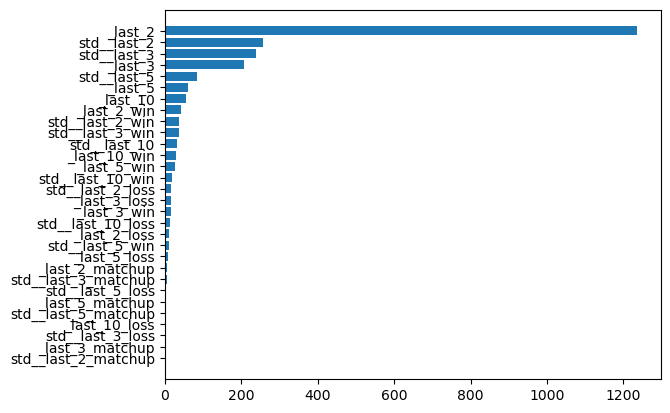

In [5]:
from sklearn.decomposition import PCA
from collections import defaultdict
import matplotlib.pyplot as plt

pca = PCA()
results = defaultdict(lambda: 0)
STATS = ["adr", "assist", "deaths", "fkdiff", "flashAssists", "headshots", "kast", "kills"]
# STATS = ["adr", "deaths", "kast", "kills"]

for stat in STATS:
    subString = stat + "_last"
    features = []
    # Iterate through the columns and check for substrings
    for column in df_processed_final.columns:
        if subString in column and not "expected" in column:
            features.append(column)
    print(features)
    
    comp = pca.fit_transform(in_sample[features])
    # print(pca.explained_variance_ratio_)

    top10 = np.abs(np.round(comp[0:10].T, decimals = 3))
    data = pd.DataFrame(top10, features, [f'PC {i+1} ({var:.1f}%)' for i, var in enumerate(pca.explained_variance_ratio_ * 100)][0:10])
    
    for series_name, series in data.items():
        #print(series_name)
        seriesArray = list(zip(series,series.index))
        seriesArray.sort(key = lambda x: x[0], reverse=True)
        # print (seriesArray)
        idx = 0
        while idx < 20:
            gen = seriesArray[idx][1].replace(stat, '')
            results[gen] += seriesArray[idx][0]
            idx += 1

results = dict(sorted(results.items(), key=lambda item: item[1]))
keys = list(results.keys())
print(keys[::-1])
plt.barh(list(results.keys()), list(results.values()))
plt.plot()


In [10]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import RFECV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import Lasso, LogisticRegression
import json

def prepare_data(df, target_column, feature_columns):
    X = df[feature_columns]
    y = df[target_column]
    return train_test_split(X, y, test_size=0.2, shuffle=False)


def train_model(X_train, y_train, model, param_grid, feature_selection=False):
    steps = [('scaler', StandardScaler()), ('model', model)]
    
    if feature_selection:
        # Using RFECV for feature selection
        selector = RFECV(estimator=model, step=1, cv=TimeSeriesSplit(n_splits=5))
        steps.insert(1, ('selector', selector))
    
    pipeline = Pipeline(steps)
    time_split = TimeSeriesSplit(n_splits=5)
    grid_search = GridSearchCV(pipeline, param_grid, cv=time_split)
    grid_search.fit(X_train, y_train)
    
    return grid_search


def evaluate_model(grid_search, X_test, y_test):
    y_pred = grid_search.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    print(f"Mean Squared Error: {mse}")
    print(f"R2 score          : {r2}")
    
    if hasattr(grid_search.best_estimator_, 'named_steps') and \
       'model' in grid_search.best_estimator_.named_steps:
        model = grid_search.best_estimator_.named_steps['model']
        if hasattr(model, 'coef_'):
            print("\nFeature Weights:")
            weights = model.coef_
            features = X_test.columns
            if isinstance(model, LogisticRegression):
                weights = weights[0]
            for feature, weight in zip(features, weights):
                print(f"{feature}: {weight:.4f}")
            
            return list(zip(features, weights))

def get_model_weights(grid_search):
    if hasattr(grid_search.best_estimator_, 'named_steps') and \
       'model' in grid_search.best_estimator_.named_steps:
        model = grid_search.best_estimator_.named_steps['model']
        if hasattr(model, 'coef_'):
            weights = model.coef_.tolist()
            #print(dir(grid_search.best_estimator_))
            #features = grid_search.best_estimator_.named_steps['scaler'].get_feature_names_out().tolist()
            features = ['x' for x in range(len(weights))]
            intercept = model.intercept_.item()
            model_weights = {'features': dict(zip(features, weights)), 'intercept': intercept}
            return json.dumps(model_weights, indent=4)
    return json.dumps({})

def model_pipeline(df, stat, model, param_grid, feature_columns_input = None, feature_selection=False):
    df = df.copy()
    target_column = f"{stat}_expected"
    if feature_columns_input is None:
        feature_columns = [column_name for column_name in df.columns if f"{stat}_" in column_name and "expected" not in column_name]
    else:
        feature_columns = feature_columns_input
    print(feature_columns)
    df = df.dropna(subset=[target_column])
    X_train, X_test, y_train, y_test = prepare_data(df, target_column, feature_columns)
    grid_search = train_model(X_train, y_train, model, param_grid, feature_selection)
    print("Best Parameters:", grid_search.best_params_)
    feat_coef = evaluate_model(grid_search, X_test, y_test)
    """
    model_weights_json = get_model_weights(grid_search)
    with open("model.json", 'w') as file:
        json.dump(model_weights_json, file, indent=4)
    print("\nModel Weights (JSON):", model_weights_json)
    """
    return feat_coef

In [38]:
"""
This module does pulls in the model, predicts, and evaluates those predictions.
"""

from collections import defaultdict

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import norm

from fetch_raw_data import get_data_from_table
from model import model_pipeline

def get_external_preds(odds_table, stats, median = False):
    """
    Fetch DF with mean/median of other bookmaker's predictions

    Args:
        odds_table (List): Raw data obtained from database.
        stats (List): List of stats that bookmakers have a prediction on.
        median (Bool): Use median of different bookmaker predictions

    Returns:
        df (pd.DataFrame): Dataframe with bookmakers stat predictions indexed on gameid and playerid
    """
    print("Creating external predictions table")
    agg = np.median if median else np.mean
    game_ids = []
    player_id = []
    player_names = []
    player_prediction = defaultdict(lambda: [])
    game_date = []
    for item in odds_table:
        if 'teams' in item and item['date']['S'] >= "2023-10-01":
            for team in item['teams']['L']:
                for player in team['M']['players']['L']:
                    if 'projections' in player['M']:
                        # print(item['date']['S'])
                        game_ids.append(item['gameid']['S'])
                        game_date.append(item['date']['S'])
                        player_id.append(player['M']['id']['S'])
                        player_names.append(player['M']['username']['S'])
                        projection_map = player['M']['projections']['M']
                        for stat in stats:
                            book_maker_pred_map = projection_map[f'{stat}']['M']
                            book_maker_pred_list = []
                            for book_maker in book_maker_pred_map.keys():
                                if len(book_maker_pred_map[book_maker]['L']) != 0:
                                    for idx in range(1, len(book_maker_pred_map[book_maker]['L']) + 1):
                                     if 'M' in book_maker_pred_map[book_maker]['L'][-idx]:
                                        pred = float(
                                            *book_maker_pred_map[book_maker]['L'][-idx]['M']['line'].values())
                                        book_maker_pred_list.append(pred)
                                        break
                            player_prediction[f"{stat}_external_pred"].append(
                                agg(book_maker_pred_list))
    df = pd.DataFrame()
    # if new trackers are being added make sure you add it here
    df['game_id'] = game_ids
    df['player_id'] = player_id
    for item in player_prediction.items():
        df[item[0].lower()] = item[1]
    return df


def get_prev_preds(pregame_table, stats_tracked):
    """
    Fetch DF with other our previous predictions.

    Args:
        pregame_table (List): Raw data obtained from database.
        stats_tracked (List): List of stats that we have a prediction on.

    Returns:
        df (pd.DataFrame): Dataframe with our predictions indexed on gameid and playerid
    """
    # features tracked, you can add position as required
    print("Creating prev pred table")
    game_ids = []
    player_id = []
    prev_prediction = defaultdict(lambda: [])

    stats = stats_tracked
    for item in pregame_table:
        if 'teams' in item.keys() and item['date']['S'] >= "2023-10-01":
            for team in item['teams']['L']:
                for player in team['M']['players']['L']:
                    if 'projections' in player['M']:
                        player_id.append(player['M']['id']['S'])
                        game_ids.append(item['gameid']['S'])

                        for stat in stats:
                            pred = None
                            if f'{stat}_prediction' in player['M']['projections']['M'].keys():
                                pred = float(
                                    player['M']['projections']['M'][f'{stat}_prediction']['N'])
                            prev_prediction[f'{stat}_previous'].append(pred)
    df = pd.DataFrame()
    # if new trackers are being added make sure you add it here
    df['game_id'] = game_ids
    df['player_id'] = player_id
    for item in prev_prediction.items():
        df[item[0].lower()] = item[1]
    return df


def add_external_pred(in_sample, oos, stats, df_odds):
    """
    Adds external bookmaker predictions onto samples.

    Args:
        in_sample (DataFrame): In sample.
        oos (DataFrame): List of stats that we have a prediction on.
        stats (List): List of stats to get bookmaker prediction on.
        df_odds (List): Raw data drawn from the database.
    Returns:
        in_sample_ext, oos_ext (pd.DataFrame): Dataframes with bookmaker predictions joined.
    """
    ext_pred = get_external_preds(df_odds, stats).dropna()
    in_sample_ext = in_sample.merge(ext_pred, how="left", on=["game_id", "player_id"]).dropna(
        subset=[x.lower()+"_external_pred" for x in stats])
    oos_ext = oos.merge(ext_pred, how="left", on=["game_id", "player_id"]).dropna(
        subset=[x.lower() +"_external_pred" for x in stats])
    return in_sample_ext, oos_ext


def add_prev_pred(in_sample, oos, stats, df_prev):
    """
    Adds our previous predictions onto samples.

    Args:
        in_sample (DataFrame): In sample.
        oos (DataFrame): List of stats that we have a prediction on.
        stats (List): List of stats to get bookmaker predictiosn on.
        df_odds (List): Raw data drawn from the database.
    Returns:
        in_sample_ext, oos_ext (pd.DataFrame): Dataframes with our previous predictions joined.
    """
    prev_pred = get_prev_preds(df_prev, stats).dropna()
    prev_pred = prev_pred.rename(columns={"assists_previous":"assist_previous"})
    stats = ["adr", "assist", "deaths", "headshots", "kast", "kills"]
    in_sample_pred = in_sample.merge(prev_pred, how="left", on=[
                                     "game_id", "player_id"]).dropna(subset=[x+"_previous" for x in stats])
    oos_pred = oos.merge(prev_pred, how="left", on=["game_id", "player_id"]).dropna(
        subset=[x+"_previous" for x in stats])
    return in_sample_pred, oos_pred


def player_metric_eval(val1, val1_name, val2, val2_name, histogram=False):
    """
    Given two lists of numbers, calculates and prints out their mse and R2 score. Optionally 
    prints a histogram of the distribution.

    Args:
        val1 (List): val1.
        val2 (List): val2.
        histogram (Bool): List of stats to get bookmaker predictiosn on.

    Returns:
        error (List): List of difference between val1 and val2 elementwise
    """
    if len(val1) == 0 or len(val2) == 0:
        print("Not enough data!")
        return None
    mse = mean_squared_error(val1, val2)
    r2 = r2_score(val1, val2)
    print(f"mse: {mse}")
    print(f"r2:  {r2}")

    if histogram:
        data = val1 - val2
        mu, std = norm.fit(data)
        upper = round(np.percentile(data, 90), 2)
        lower = round(np.percentile(data, 10), 2)
        text = (f'10th/90th percentile at: {lower}/{upper}.\n'
                f'Min/Max: {round(data.min(), 2)}/{round(data.max(), 2)}\n'
                f'Mean and STD: {round(mu, 4)}/{round(std, 4)}.')

        plt.hist(val1 - val2, bins=50, alpha=0.5, density=True)
        plt.axvline(x=upper, label="90th percentile")
        plt.axvline(x=lower, label="10th percentile")
        plt.axvline(x=mu, label="Mean")

        x = np.linspace(data.min(), data.max(), 1000)
        p = norm.pdf(x, mu, std)
        plt.plot(x, p, label="Normal Fit")

        plt.ylabel("Amount in bin")
        plt.xlabel(f'Difference bins')
        plt.legend(loc="upper left")
        plt.title(f'Difference between {val1_name} and {val2_name}')
        plt.figtext(0.5, -0.07, text, wrap=True, horizontalalignment='center', fontsize=9)

        plt.savefig(f'/home/frank/Desktop/Rimble/personalMlPipeline/ml-pipeline/tests/testRun/{val1_name}_diff_{val2_name}.png')
        plt.show()

    error = np.array(val1 - val2)
    return error


def eval_predictions(model, stats, oos, in_sample, bias, external_metric_eval=False, compare_to_prev_preds=False, ext_stats=[], 
                     exp_stats=[], odds_table=None, pregame_table=None, testing=False, df_odds = None, df_prev = None):
    """
    Trains and evaluates a lasso regression model. 

    Args:
        model (modelClass): sklearn linear model.
        stats (List): Stats to predict and evaluate on.
        oos (DataFrame): Out of sample data.
        in_sample (DataFrame): In sample data. 
        external_metric_eval (Bool): Evaluate based on external bookmaker predictions
        compare_to_prev_preds (Bool): Evaluate based on our previous predictions
        ext_stats (List): List of stats to get bookmaker prediction on.
        exp_stats (List): List of stats that we have a pervious prediction on.
        odds_table (List): Raw data of bookmaker predictions drawn from the database.
        pregame_table (List): Raw data of our previous predictions drawn from the database.
        testing (Bool): Testing?


    Returns:
        distributions (Dict): Dictionary of stats as key, and list of errors between predicted and expected values as value.
    """
    param_grid = {'model__alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100]}

    # Running the pipeline
    distributions = {}

    # if external_metric_eval:
    # #     df_odds = get_data_from_table(odds_table, testing)
    #     in_sample_ext, oos_ext = add_external_pred(
    #         in_sample, oos, ext_stats, df_odds)

    # if compare_to_prev_preds:
    # #     df_prev = get_data_from_table(pregame_table, testing)
    #     in_sample_prev, oos_prev = add_prev_pred(
    #         in_sample, oos, exp_stats, df_prev)

    for stat in stats:
        # default_feature_list = [
        #     f'{stat}_last_2', 
        #     f'{stat}_last_10',
        #     f'std_{stat}_last_2',
        #     # f'{stat}_last_10_win',
        #     # f'{stat}_last_10_loss',
        #     f'{stat}_last_2_extension',
        #     f'{stat}_last_10_matchup',
        # ]
        default_feature_list = [f'{stat}_last_2', f'std_{stat}_last_2', f'std_{stat}_last_3', f'{stat}_last_3', 
                                f'{stat}_last_5', f'std_{stat}_last_10', f'{stat}_last_3_win', f'std_{stat}_last_5', 
                                f'std_{stat}_last_3_win', f'std_{stat}_last_10_win', f'{stat}_last_5_win', 
                                f'std_{stat}_last_2_win', f'{stat}_last_10', f'{stat}_last_10_win', 
                                f'std_{stat}_last_5_win', f'{stat}_last_2_loss', f'{stat}_last_3_loss', 
                                f'std_{stat}_last_3_loss', f'std_{stat}_last_2_loss', f'{stat}_last_10_loss', 
                                f'{stat}_last_2_win', f'std_{stat}_last_10_loss', f'{stat}_last_2_matchup',
                                f'std_{stat}_last_5_loss', f'{stat}_last_5_matchup', f'std_{stat}_last_3_matchup', 
                                f'std_{stat}_last_5_matchup']
        # Running the pipeline
        feat_coef = model_pipeline(
            in_sample, stat, model, param_grid,
            feature_selection=False,
            feature_columns_input=default_feature_list
        )

        # while len([_x for _x in feat_coef if _x[1] < 0]):
        #     # remove the feature that is getting a negative score
        #     for feat_name, coef in feat_coef:
        #         if coef < 0:
        #             print(f"REMOVING FEATURE WITH < 0 COEF: {feat_name}")
        #             default_feature_list.remove(feat_name)
        #     feat_coef = model_pipeline(
        #         in_sample, stat, model, param_grid,
        #         feature_selection=False,
        #         feature_columns_input=default_feature_list
        #     )

        print("raw coef: ", feat_coef)
        normalize_coefs = sum([_x[1] for _x in feat_coef])
        normalized_feat_coef = [(_f, _c/normalize_coefs)
                                for _f, _c in feat_coef]
        print("norm coef:", normalized_feat_coef)

        def calculate_prediction(row):
            return sum(nc*row[f] for f, nc in normalized_feat_coef) + bias[stat]

        print(stat)
        in_sample[f'{stat}_prediction'] = in_sample.apply(
            calculate_prediction, axis=1)
        oos[f'{stat}_prediction'] = oos.apply(calculate_prediction, axis=1)

        in_sample = in_sample.dropna(
            subset=[f'{stat}_expected', f'{stat}_prediction'])
        oos = oos.dropna(subset=[f'{stat}_expected', f'{stat}_prediction'])

        # print("In sample metrics:")
        # player_metric_eval(
        #     in_sample[f"{stat}_expected"], f"{stat}_expected", in_sample[f'{stat}_prediction'], f'{stat}_prediction')

        print("In Sample OT metrics")
        print("Average Bias: ", np.mean(in_sample[f"{stat}_expected_OT"] - in_sample[f'{stat}_prediction']))
        distributions[stat] = player_metric_eval(
            in_sample[f"{stat}_expected_OT"], f"{stat}_expected_OT", in_sample[f'{stat}_prediction'], f'{stat}_prediction')
        
        print("OOS OT metrics")
        distributions[stat] = player_metric_eval(
            oos[f"{stat}_expected_OT"], f"{stat}_expected_OT", oos[f'{stat}_prediction'], f'{stat}_prediction', True)
        
        
        if external_metric_eval and stat in [x.lower() for x in ext_stats]:
            in_sample_ext, oos_ext = add_external_pred(
                in_sample, oos, ext_stats, df_odds)
            # in_sample_ext = pd.read_pickle("/Users/admin/Desktop/Rimble/ml-pipeline/in_sample_ext.pkl")
            # oos_ext = pd.read_pickle("/Users/admin/Desktop/Rimble/ml-pipeline/oos_ext.pkl")

            print("\nIn sample: ")
            print("Expected OT to External Prediction")
            player_metric_eval(
                in_sample_ext[f"{stat}_expected_OT"],  f"{stat}_expected_OT", in_sample_ext[f'{stat}_external_pred'], f'{stat}_external_pred')

            print("Internal to External Prediction")
            player_metric_eval(
                in_sample_ext[f"{stat}_prediction"], f"{stat}_prediction", in_sample_ext[f'{stat}_external_pred'], f'{stat}_external_pred')

            print("\nOOS: ")
            print("Expected OT to External Prediction")
            player_metric_eval(
                oos_ext[f"{stat}_expected_OT"], f"{stat}_expected_OT", oos_ext[f'{stat}_external_pred'],  f"{stat}_external_pred", True)

            print("Internal to External Prediction")
            player_metric_eval(
                oos_ext[f"{stat}_prediction"], f"{stat}_prediction", oos_ext[f'{stat}_external_pred'], f"{stat}_external_pred")

        if compare_to_prev_preds and stat in exp_stats:
            in_sample_prev, oos_prev = add_prev_pred(
                in_sample, oos, exp_stats, df_prev)
            
            # in_sample_prev = pd.read_pickle("/Users/admin/Desktop/Rimble/ml-pipeline/in_sample_prev.pkl")
            # oos_prev = pd.read_pickle("/Users/admin/Desktop/Rimble/ml-pipeline/oos_prev.pkl")
            print("\nIn sample: ")
            print("New Internal to Old Internal Prediction")
            player_metric_eval(
                in_sample_prev[f"{stat}_prediction"], f"{stat}_prediction", in_sample_prev[f'{stat}_previous'], f'{stat}_previous' + '_prediction')

            print("\nOOS: ")
            print("New Internal to Old Internal Prediction")
            player_metric_eval(
                oos_prev[f"{stat}_prediction"], f"{stat}_prediction", oos_prev[f'{stat}_previous'], f'{stat}_previous' + '_prediction')
            
            print("\nIn sample: ")
            print("Expected to Old Internal Prediction")
            player_metric_eval(
                in_sample_prev[f"{stat}_expected_OT"], f"{stat}_expected_OT", in_sample_prev[f'{stat}_previous'], f'{stat}_previous' + '_prediction')
            
            print("\nOOS: ")
            print("Expected OT to Old Internal Prediction")
            player_metric_eval(
                oos_prev[f"{stat}_expected_OT"], f"{stat}_expected_OT", oos_prev[f'{stat}_previous'], f'{stat}_previous' + '_prediction')
            currMse = mean_squared_error(oos_prev[f"{stat}_expected_OT"], oos_prev[f'{stat}_prediction'])
            prevMse = mean_squared_error(oos_prev[f"{stat}_expected_OT"], oos_prev[f'{stat}_previous'])
            print("Change (Increase in accuracy): ", (1-currMse/prevMse)*100)
        print("====================================================================")
    return distributions


In [12]:
STATS = ["adr", "assist", "deaths", "fkdiff", "flashAssists", "headshots", "kast", "kills"]
EXTERNAL_STATS = ["Kills", "Headshots"]
PREV_STATS = ["adr", "assists", "deaths", "headshots", "kast", "kills"]
ODDS_TABLE = "csgo-odds"
PREGAME_TABLE = "pregamecsgo_completed_matches"


In [ ]:
df_odds = get_data_from_table(ODDS_TABLE, False)

In [ ]:
df_prev = get_data_from_table(PREGAME_TABLE, False)

In [13]:
import pickle
# with open("/home/frank/Desktop/Rimble/personalMlPipeline/ml-pipeline/cache/cacheNoOvertime/df_odds.pkl", 'wb') as f:
#    pickle.dump(df_odds, f)
with open('/home/frank/Desktop/Rimble/personalMlPipeline/ml-pipeline/cache/df_odds.pkl', 'rb') as f:
   df_odds = pickle.load(f)
with open('/home/frank/Desktop/Rimble/personalMlPipeline/ml-pipeline/cache/df_prev.pkl', 'rb') as f:
   df_prev = pickle.load(f)

['adr_last_2', 'std_adr_last_2', 'std_adr_last_3', 'adr_last_3', 'adr_last_5', 'std_adr_last_10', 'adr_last_3_win', 'std_adr_last_5', 'std_adr_last_3_win', 'std_adr_last_10_win', 'adr_last_5_win', 'std_adr_last_2_win', 'adr_last_10', 'adr_last_10_win', 'std_adr_last_5_win', 'adr_last_2_loss', 'adr_last_3_loss', 'std_adr_last_3_loss', 'std_adr_last_2_loss', 'adr_last_10_loss', 'adr_last_2_win', 'std_adr_last_10_loss', 'adr_last_2_matchup', 'std_adr_last_5_loss', 'adr_last_5_matchup', 'std_adr_last_3_matchup', 'std_adr_last_5_matchup']
Best Parameters: {'model__alpha': 0.01}
Mean Squared Error: 215.1013783436281
R2 score          : 0.18965036752804565

Feature Weights:
adr_last_2: 0.2764
std_adr_last_2: -0.1074
std_adr_last_3: -0.0607
adr_last_3: 0.3454
adr_last_5: -0.0000
std_adr_last_10: -0.0000
adr_last_3_win: -0.4542
std_adr_last_5: -0.0017
std_adr_last_3_win: -0.0248
std_adr_last_10_win: -0.1641
adr_last_5_win: -1.5021
std_adr_last_2_win: 0.1316
adr_last_10: -0.2964
adr_last_10_win:

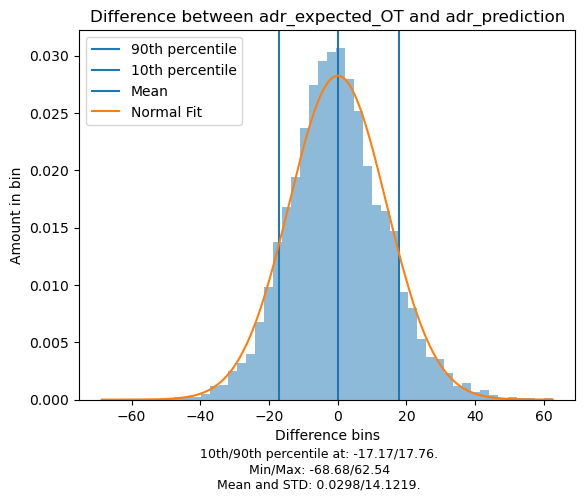

Creating prev pred table

In sample: 
New Internal to Old Internal Prediction
mse: 56.663836703430285
r2:  -0.26733658625012025

OOS: 
New Internal to Old Internal Prediction
mse: 49.87441735067381
r2:  -0.04253210575348443

In sample: 
Expected to Old Internal Prediction
mse: 231.43672515307077
r2:  0.036445575271499275

OOS: 
Expected OT to Old Internal Prediction
mse: 232.06383362357704
r2:  0.05552670870817222
Change (Increase in accuracy):  14.521544933504183
['assist_last_2', 'std_assist_last_2', 'std_assist_last_3', 'assist_last_3', 'assist_last_5', 'std_assist_last_10', 'assist_last_3_win', 'std_assist_last_5', 'std_assist_last_3_win', 'std_assist_last_10_win', 'assist_last_5_win', 'std_assist_last_2_win', 'assist_last_10', 'assist_last_10_win', 'std_assist_last_5_win', 'assist_last_2_loss', 'assist_last_3_loss', 'std_assist_last_3_loss', 'std_assist_last_2_loss', 'assist_last_10_loss', 'assist_last_2_win', 'std_assist_last_10_loss', 'assist_last_2_matchup', 'std_assist_last_5_

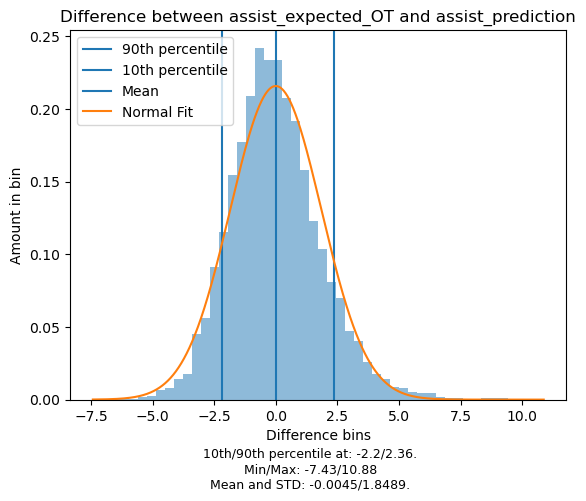

['deaths_last_2', 'std_deaths_last_2', 'std_deaths_last_3', 'deaths_last_3', 'deaths_last_5', 'std_deaths_last_10', 'deaths_last_3_win', 'std_deaths_last_5', 'std_deaths_last_3_win', 'std_deaths_last_10_win', 'deaths_last_5_win', 'std_deaths_last_2_win', 'deaths_last_10', 'deaths_last_10_win', 'std_deaths_last_5_win', 'deaths_last_2_loss', 'deaths_last_3_loss', 'std_deaths_last_3_loss', 'std_deaths_last_2_loss', 'deaths_last_10_loss', 'deaths_last_2_win', 'std_deaths_last_10_loss', 'deaths_last_2_matchup', 'std_deaths_last_5_loss', 'deaths_last_5_matchup', 'std_deaths_last_3_matchup', 'std_deaths_last_5_matchup']
Best Parameters: {'model__alpha': 0.01}
Mean Squared Error: 4.024837078774181
R2 score          : 0.44149713461918705

Feature Weights:
deaths_last_2: -0.0000
std_deaths_last_2: 0.0101
std_deaths_last_3: -0.0000
deaths_last_3: 0.0000
deaths_last_5: -0.0000
std_deaths_last_10: 0.0035
deaths_last_3_win: -0.0000
std_deaths_last_5: 0.0246
std_deaths_last_3_win: 0.0000
std_deaths_l

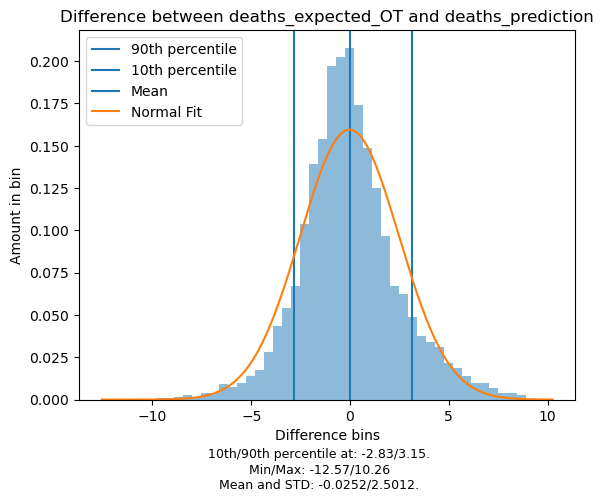

Creating prev pred table

In sample: 
New Internal to Old Internal Prediction
mse: 5.798606710460953
r2:  -1.0705456920167884

OOS: 
New Internal to Old Internal Prediction
mse: 4.568094523710379
r2:  -0.693238189727539

In sample: 
Expected to Old Internal Prediction
mse: 12.070139251591796
r2:  -0.2752344537939104

OOS: 
Expected OT to Old Internal Prediction
mse: 10.56526711545882
r2:  -0.20550562083171675
Change (Increase in accuracy):  41.50153242841558
['fkdiff_last_2', 'std_fkdiff_last_2', 'std_fkdiff_last_3', 'fkdiff_last_3', 'fkdiff_last_5', 'std_fkdiff_last_10', 'fkdiff_last_3_win', 'std_fkdiff_last_5', 'std_fkdiff_last_3_win', 'std_fkdiff_last_10_win', 'fkdiff_last_5_win', 'std_fkdiff_last_2_win', 'fkdiff_last_10', 'fkdiff_last_10_win', 'std_fkdiff_last_5_win', 'fkdiff_last_2_loss', 'fkdiff_last_3_loss', 'std_fkdiff_last_3_loss', 'std_fkdiff_last_2_loss', 'fkdiff_last_10_loss', 'fkdiff_last_2_win', 'std_fkdiff_last_10_loss', 'fkdiff_last_2_matchup', 'std_fkdiff_last_5_loss',

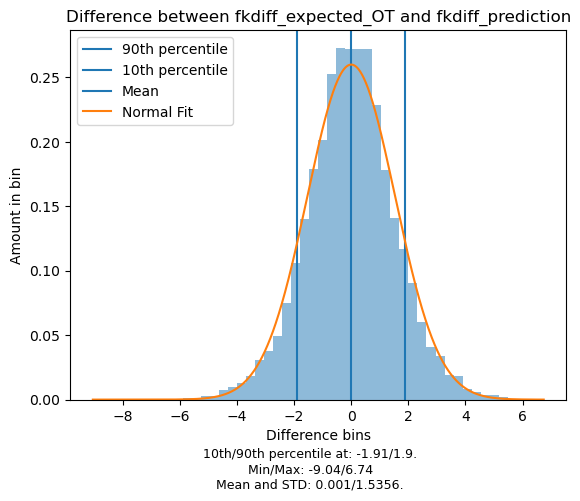

['flashAssists_last_2', 'std_flashAssists_last_2', 'std_flashAssists_last_3', 'flashAssists_last_3', 'flashAssists_last_5', 'std_flashAssists_last_10', 'flashAssists_last_3_win', 'std_flashAssists_last_5', 'std_flashAssists_last_3_win', 'std_flashAssists_last_10_win', 'flashAssists_last_5_win', 'std_flashAssists_last_2_win', 'flashAssists_last_10', 'flashAssists_last_10_win', 'std_flashAssists_last_5_win', 'flashAssists_last_2_loss', 'flashAssists_last_3_loss', 'std_flashAssists_last_3_loss', 'std_flashAssists_last_2_loss', 'flashAssists_last_10_loss', 'flashAssists_last_2_win', 'std_flashAssists_last_10_loss', 'flashAssists_last_2_matchup', 'std_flashAssists_last_5_loss', 'flashAssists_last_5_matchup', 'std_flashAssists_last_3_matchup', 'std_flashAssists_last_5_matchup']
Best Parameters: {'model__alpha': 0.001}
Mean Squared Error: 0.6700253782200339
R2 score          : 0.218389970659143

Feature Weights:
flashAssists_last_2: -0.0057
std_flashAssists_last_2: 0.0009
std_flashAssists_las

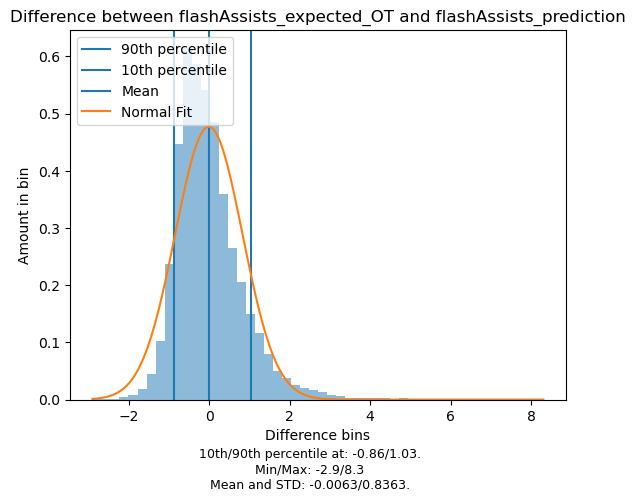

['headshots_last_2', 'std_headshots_last_2', 'std_headshots_last_3', 'headshots_last_3', 'headshots_last_5', 'std_headshots_last_10', 'headshots_last_3_win', 'std_headshots_last_5', 'std_headshots_last_3_win', 'std_headshots_last_10_win', 'headshots_last_5_win', 'std_headshots_last_2_win', 'headshots_last_10', 'headshots_last_10_win', 'std_headshots_last_5_win', 'headshots_last_2_loss', 'headshots_last_3_loss', 'std_headshots_last_3_loss', 'std_headshots_last_2_loss', 'headshots_last_10_loss', 'headshots_last_2_win', 'std_headshots_last_10_loss', 'headshots_last_2_matchup', 'std_headshots_last_5_loss', 'headshots_last_5_matchup', 'std_headshots_last_3_matchup', 'std_headshots_last_5_matchup']
Best Parameters: {'model__alpha': 0.001}
Mean Squared Error: 5.252691492341414
R2 score          : 0.25420172556894705

Feature Weights:
headshots_last_2: 0.0203
std_headshots_last_2: -0.0128
std_headshots_last_3: -0.0008
headshots_last_3: 0.0499
headshots_last_5: 0.0008
std_headshots_last_10: 0.0

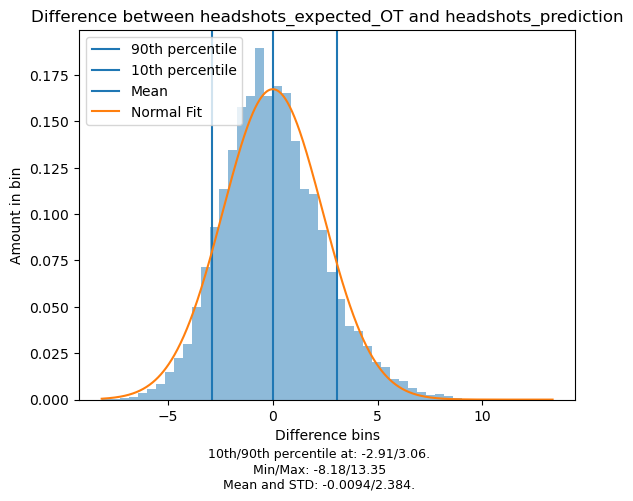

Creating external predictions table

In sample: 
Expected OT to External Prediction
mse: 5.7834296171171165
r2:  0.22072255974975497
Internal to External Prediction
mse: 1.0382663493554642
r2:  0.1973732441403968

OOS: 
Expected OT to External Prediction
mse: 5.809596693292518
r2:  0.2149607769506543


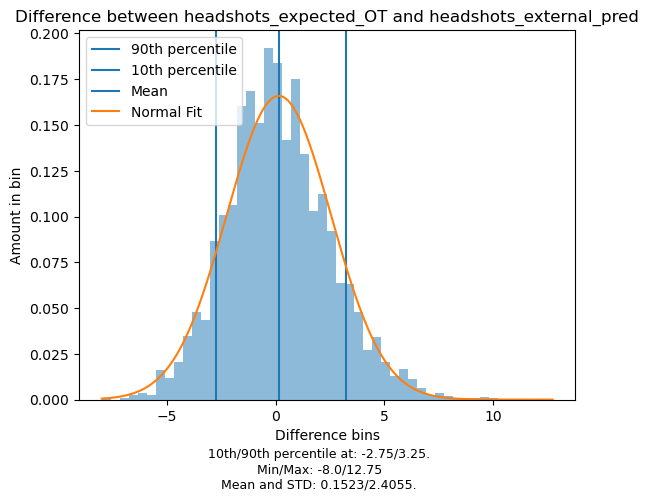

Internal to External Prediction
mse: 0.853845178274384
r2:  0.4146829126840006
Creating prev pred table

In sample: 
New Internal to Old Internal Prediction
mse: 1.111145549336174
r2:  0.13962143955717232

OOS: 
New Internal to Old Internal Prediction
mse: 0.9484526104827814
r2:  0.3403397082510067

In sample: 
Expected to Old Internal Prediction
mse: 6.234141332956832
r2:  0.16798244397125073

OOS: 
Expected OT to Old Internal Prediction
mse: 6.0706826489909105
r2:  0.17639260922089228
Change (Increase in accuracy):  7.500609850014706
['kast_last_2', 'std_kast_last_2', 'std_kast_last_3', 'kast_last_3', 'kast_last_5', 'std_kast_last_10', 'kast_last_3_win', 'std_kast_last_5', 'std_kast_last_3_win', 'std_kast_last_10_win', 'kast_last_5_win', 'std_kast_last_2_win', 'kast_last_10', 'kast_last_10_win', 'std_kast_last_5_win', 'kast_last_2_loss', 'kast_last_3_loss', 'std_kast_last_3_loss', 'std_kast_last_2_loss', 'kast_last_10_loss', 'kast_last_2_win', 'std_kast_last_10_loss', 'kast_last_2_ma

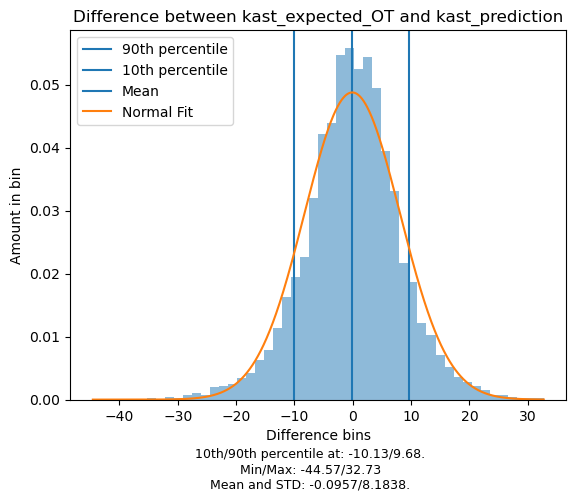

Creating prev pred table

In sample: 
New Internal to Old Internal Prediction
mse: 46.548959153075096
r2:  0.02886097746551175

OOS: 
New Internal to Old Internal Prediction
mse: 43.96049735171516
r2:  0.11566355919177018

In sample: 
Expected to Old Internal Prediction
mse: 94.79906706876689
r2:  0.04319901486911282

OOS: 
Expected OT to Old Internal Prediction
mse: 96.38728249975333
r2:  0.06654809865073164
Change (Increase in accuracy):  31.228023963727026
['kills_last_2', 'std_kills_last_2', 'std_kills_last_3', 'kills_last_3', 'kills_last_5', 'std_kills_last_10', 'kills_last_3_win', 'std_kills_last_5', 'std_kills_last_3_win', 'std_kills_last_10_win', 'kills_last_5_win', 'std_kills_last_2_win', 'kills_last_10', 'kills_last_10_win', 'std_kills_last_5_win', 'kills_last_2_loss', 'kills_last_3_loss', 'std_kills_last_3_loss', 'std_kills_last_2_loss', 'kills_last_10_loss', 'kills_last_2_win', 'std_kills_last_10_loss', 'kills_last_2_matchup', 'std_kills_last_5_loss', 'kills_last_5_matchup'

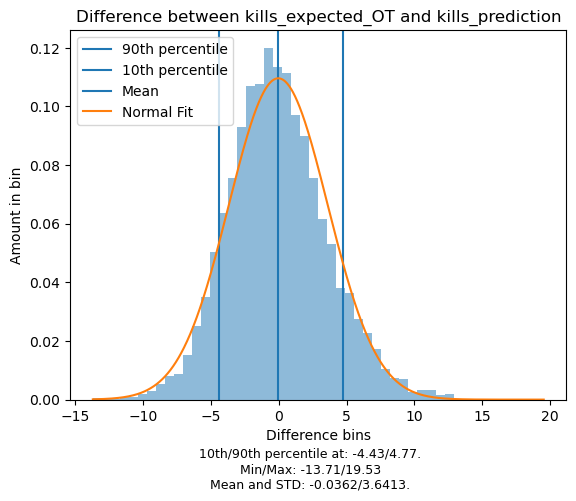

Creating external predictions table

In sample: 
Expected OT to External Prediction
mse: 14.50187543821647
r2:  0.09830936822722403
Internal to External Prediction
mse: 2.877598942118293
r2:  0.009451720471304714

OOS: 
Expected OT to External Prediction
mse: 14.467051287048994
r2:  0.10301665587446884


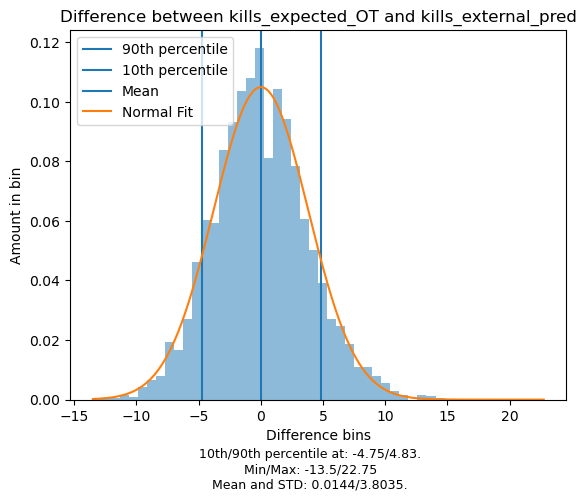

Internal to External Prediction
mse: 2.6604031998546724
r2:  0.11485707297736036
Creating prev pred table

In sample: 
New Internal to Old Internal Prediction
mse: 4.974724169702568
r2:  -0.6734180042161677

OOS: 
New Internal to Old Internal Prediction
mse: 4.152172331626101
r2:  -0.35691973705152336

In sample: 
Expected to Old Internal Prediction
mse: 17.15190845879657
r2:  -0.05209796332370198

OOS: 
Expected OT to Old Internal Prediction
mse: 16.06723493870266
r2:  -0.023730693114836443
Change (Increase in accuracy):  18.57036062114884


In [39]:
from sklearn.linear_model import Lasso
model = Lasso()
# bias = {'adr':0, 'deaths': 0, "assist":0, "fkdiff":0, "flashAssists":0,
#         'headshots':0, 'kast': 0, 'kills':0}
bias = {'adr':-2.9834641990807764, "assist":-0.04458039695826739, 'deaths': 1.2883667649028532,  "fkdiff":0.056746782265507896, "flashAssists":0.01000014791830784,
        'headshots':0.1520348353560839, 'kast': 0.32643197693985293, 'kills':0.5763398484988652}
distributions = eval_predictions(model, STATS, oos, in_sample, bias, True, True, EXTERNAL_STATS,
                                 PREV_STATS, ODDS_TABLE, PREGAME_TABLE, testing=False, df_odds = df_odds, df_prev = df_prev)